<a href="https://colab.research.google.com/github/IA2122/practica-4-paochoa/blob/main/practica4_ampliacion_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 4 Ampliación II. Visualización de datasets

En este notebook veremos distintas técnicas de reducción de la dimensionalidad que sirven para ser capaces de visualizar datasets en altas dimensiones. Para ilustrarlas utilizaremos de nuevo el dataset de los dígitos. 

Como hemos comentado en teoría los datasets de altas dimensiones son difíciles de visualizar. Mientras que los datos en dos o tres dimensiones se pueden visualizar para mostrar la estructura interna de los datos, esto no es posible en dimensiones más altas. Para ayudar a la visualización de la estructura de un dataset, su dimensión debe ser reducida. 

## Pasos previos 
Comenzamos cargando las librerías necesarias.

In [4]:
from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
%matplotlib inline

Cargamos el dataset de los dígitos, pero nos vamos a quedar solo con las clases del 0 al 6 para obtener una mejor visualización.

In [5]:
digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape

La siguiente función nos servirá para escalar y visualizar los dígitos.

In [7]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min) # porque se hace esto en lugar de usar un Scaler?

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):     # se coge el número de filas de X
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):      # se comprueba si offsetbox tiene un atributo llamado AnnotationBbox
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.show()

En primer lugar vamos a mostrar varias imágenes de los dígitos. 

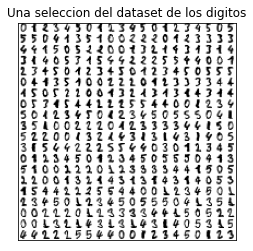

In [8]:
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('Una seleccion del dataset de los digitos')
plt.show()

## Proyección aleatoria

La manera más sencilla de reducir la dimensionalidad consiste en tomar una proyección aleatoria de los datos. Aunque esto permite cierto grado de visualización de la estructura de los datos, la aleatoreidad de la elección deja mucho que desear. En una proyección aleatoria es my probable que la mayor parte de la estructura de los datos se pierda. Esto se puede ver claramente a continuación.

Calculando la proyección aleatoria


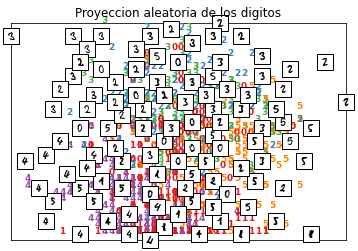

CPU times: user 2.8 s, sys: 146 ms, total: 2.94 s
Wall time: 2.93 s


In [9]:
%%time
print("Calculando la proyección aleatoria")
clf = random_projection.SparseRandomProjection(n_components=2, random_state=42) # lo que hace es elegir 2 variables de las dadas de forma aleatoria y mostrarlas
X_projected = clf.fit_transform(X)
plot_embedding(X_projected, "Proyeccion aleatoria de los digitos" )

## Técnicas lineales para la reducción de la dimensionalidad

Para resolver el problema de la aleatoreidad del método anterior, se han diseñado un número de técnicas lineales no supervisadas que permiten reducir la dimensionalidad de los datos. Estas técnicas definen maneras de proyectar los datos de manera lineal intentando conservar la mayor información posible. Estos métodos pueden ser muy poderosos, pero de manera habitual no son capaces de detectar importantes estructuras no lineales en los datos. 

Entre estos métodos lineales podemos encontrar PCA (ya visto en clase) o en análisis de discriminación lineal. 

**Nota**
Estos algoritmos de reducción de dimensionalidad NO son de clustering, lo que pasa es que al reducir la dimensionalidad se siguen manteniendo las distancias, por lo que siguen cercanos ya que son similares y por tanto cercanos en el propio dataset original

### PCA

Calculando PCA


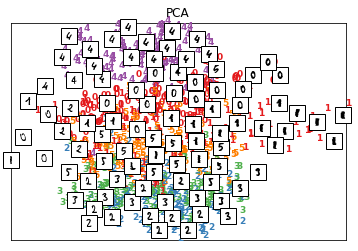

CPU times: user 2.86 s, sys: 341 ms, total: 3.2 s
Wall time: 3.02 s


In [10]:
%%time
print("Calculando PCA")
clf = decomposition.TruncatedSVD(n_components=2)
X_pca = clf.fit_transform(X)
plot_embedding(X_pca,"PCA")

### Análisis de discriminación lineal

Calculando análisis de discriminación lineal


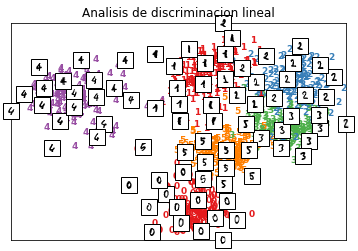

CPU times: user 2.98 s, sys: 310 ms, total: 3.29 s
Wall time: 3.15 s


In [11]:
%%time
print("Calculando análisis de discriminación lineal")
X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  
X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2).fit_transform(X2, y)
plot_embedding(X_lda, "Analisis de discriminacion lineal")

## Aprendizaje de variedades (Manifold learning)

El aprendizaje de variedades puede verse como un intento de generalizar técnicas como PCA de manera que sean sensible a estructuras no lineales en los datos. Aunque existen variantes supervisadas, el problema de aprender una variedad es no supervisado: se aprende la estructura altamente dimensional de los datos a partir de los propios datos. 

Existen diversas técnicas de aprendizaje de variedades, aquí solo veremos las que están disponibles en la librería sklearn. http://scikit-learn.org/stable/modules/manifold.html

### Isomap

Calculando Isomap


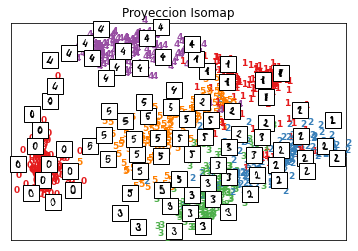

CPU times: user 6.21 s, sys: 348 ms, total: 6.56 s
Wall time: 6.86 s


In [12]:
%%time
print("Calculando Isomap")
n_neighbors = 30
n_components=2
clf = manifold.Isomap(n_neighbors=n_neighbors,n_components=n_components)
X_iso = clf.fit_transform(X)
plot_embedding(X_iso, "Proyeccion Isomap")

### LLE (Locally linear embedding)

Este método tiene varias variantes.

Calculando LLE con método estándar


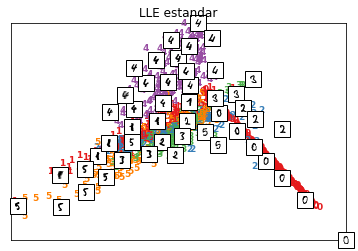

CPU times: user 4.67 s, sys: 412 ms, total: 5.09 s
Wall time: 5.21 s


In [13]:
%%time
print("Calculando LLE con método estándar")
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2,
                                      method='standard')
X_lle = clf.fit_transform(X)
plot_embedding(X_lle, "LLE estandar")

Calculando LLE con método modificado


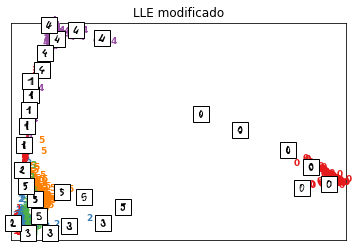

CPU times: user 5.24 s, sys: 1.04 s, total: 6.29 s
Wall time: 6.16 s


In [14]:
%%time
print("Calculando LLE con método modificado")
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2,
                                      method='modified')
X_lle = clf.fit_transform(X)
plot_embedding(X_lle, "LLE modificado")

Calculando Hessian LLE


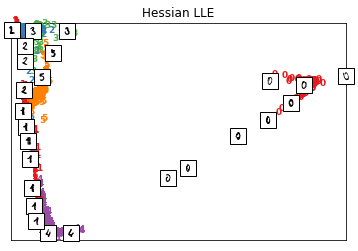

CPU times: user 5.3 s, sys: 1.63 s, total: 6.93 s
Wall time: 7.86 s


In [15]:
%%time
print("Calculando Hessian LLE")
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2,
                                      method='hessian')
X_lle = clf.fit_transform(X)
plot_embedding(X_lle, "Hessian LLE")

Calculando LTSA LLE


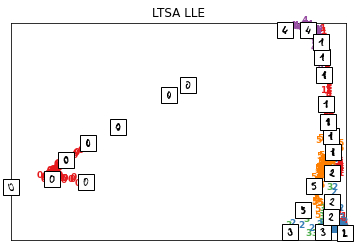

CPU times: user 5.07 s, sys: 1.29 s, total: 6.36 s
Wall time: 5.93 s


In [16]:
%%time
print("Calculando LTSA LLE")
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2,
                                      method='ltsa')
X_lle = clf.fit_transform(X)
plot_embedding(X_lle, "LTSA LLE")

### MDS

Calculando MDS embedding


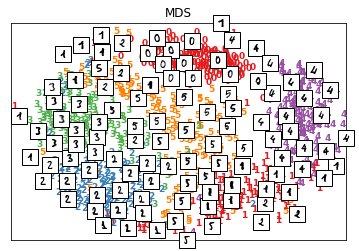

CPU times: user 8.3 s, sys: 2.51 s, total: 10.8 s
Wall time: 9.61 s


In [17]:
%%time
print("Calculando MDS embedding")
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
X_mds = clf.fit_transform(X)
plot_embedding(X_mds, "MDS")

### Spectral embedding

Calculando Spectral Embedding


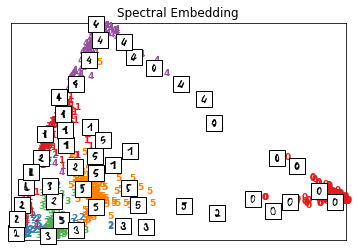

CPU times: user 4.62 s, sys: 500 ms, total: 5.12 s
Wall time: 5.16 s


In [18]:
%%time
print("Calculando Spectral Embedding")
clf = manifold.SpectralEmbedding(n_components=2, random_state=0,
                                      eigen_solver="arpack")
X_se = clf.fit_transform(X)
plot_embedding(X_se, "Spectral Embedding")

### t-SNE

Calculando t-SNE


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


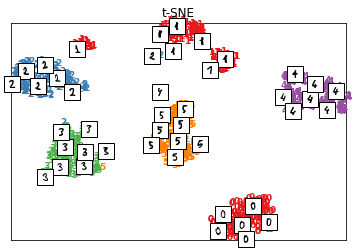

CPU times: user 38.9 s, sys: 418 ms, total: 39.3 s
Wall time: 36.2 s


In [19]:
%%time
print("Calculando t-SNE")
clf = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = clf.fit_transform(X)
plot_embedding(X_tsne, "t-SNE")

### U-map

Finalmente para usar UMAP es necesario en primer lugar instalar la librería ``umap-learn``.

In [20]:
!pip install umap-learn -Uq

     |████████████████████████████████| 86 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 39.6 MB/s 


Una vez instalado UMAP podemos cargar la librería y utilizarlo como cualquiera de los otros métodos. 

In [21]:
import umap

Calculando UMAP


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


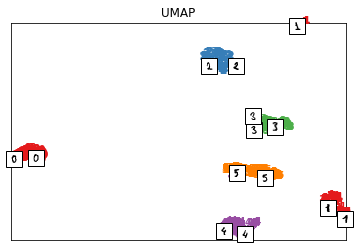

CPU times: user 27.3 s, sys: 364 ms, total: 27.7 s
Wall time: 34.6 s


In [22]:
%%time
print("Calculando UMAP")
clf = umap.UMAP()
X_umap = clf.fit_transform(X)
plot_embedding(X_umap, "UMAP")

### Ejercicio 1

Responde a continuación. ¿Cuál es el método más rápido? ¿Y el más lento?

**Respuesta**:

El método más rápido es el de proyección aleatoria, posiblemente debido a que no tiene que calcular ninguna métrica para la elección de las variables.

El método más lento es el MDS

### Ejercicio 2

Responde a continuación. Al realizar las visualizaciones ¿qué clase (digito) queda claramente separado del resto al aplicar los métodos LLE con las versiones modificado, hessian y ltsa?

**Respuesta**:

El dígito 0

### Ejercicio 3

En todas las técnicas que hemos utilizado anteriormente (salvo en el análisis de discriminación lineal) hemos seguido un esquema común para reducir la dimensionalidad y visualizar el resultado, por lo que podríamos definir una función para dicha tarea. Define dicha función y comprueba que los resultados obtenidos son los mismos que anteriormente.

In [23]:
# ya que los parámetros suelen ser diccionarios, siendo su clave el nombre y siendo su valor el propio valor del parámetro
# para indicar un conjunto de parámetros indefinido en forma de parámetro se hace con **
# kwargs es la palabra que se le suele poner cuando eso, no es una palabra clave en sí
def reduc_Dimensionalidad(fun, datos, **kwargs):
  clf = fun(args)
  X_fun = clf.fit_transform(datos)
  plot_embedding(X_fun, "Función de reducción" + fun)

```
def test(*args, **kwargs):
    print args
    print kwargs
```
```
>>test(1, 2, a=3, b=4)
(1, 2)
{'a': 3, 'b': 4}
```





## Entrega

Recuerda guardar tus cambios en tu repositorio utilizando la opción "Save a copy in GitHub..." del menú File.